*A1 Report - Wu, Sixuan*
# <center> Exploring Yelp </center>
## <center> Author: Sixuan Wu </center>
## <center> Date: February 15, 2020 </center>
***

## Introduction

Yelp is a business directory service and crowd-sourced review forum, and a public company of the same name that is headquartered in San Francisco, California. The company develops, hosts, and markets the Yelp.com website and the Yelp mobile app, which publish crowd-sourced reviews about businesses. It also operates an online reservation service called Yelp Reservations.

--adapted from Wikipedia

The development of Yelp improves people's quality of life in many ways. For example, citizens can find a nice restaurant to enjoy delicious food during weekends or they can find a fitness center nearby where they can do daily exercise. Therefore, the importance of Yelping data analysis is getting more essential which can provide public more high-quality entertainment places.

In this report, conclusions will be from three main aspects: all business on Yelp, business in GTA([Great Toronto Area](https://en.wikipedia.org/wiki/Greater_Toronto_Area)) and users reviews. The results of this report can be helpful to improve the user experience and know more about establishments in the North America and GTA.

## Data Description

The dataset I used is from [Yelp Dataset Challenge](https://www.yelp.com/dataset/challenge) which is provided by Yelp officially. The json format dataset which is compressed in tar format can be downloaded by providing email and name. Following are related [permissions](https://s3-media1.fl.yelpcdn.com/assets/srv0/engineering_pages/06cb5ad91db8/assets/vendor/yelp-dataset-agreement.pdf) of the dataset:

**Cannot Dos:**
- Use the data to create or update my own business.
- Give the data to the third party without permission of Yelp.
- Give the data to others to make profit.

**Can Dos:**
- Use information from data to do academic project in for this course.

### Extract Data

In [343]:
import tarfile
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import seaborn as sns
from textblob import TextBlob
from IPython.core.display import SVG
import plotly.graph_objects as go
import plotly.express as px
import geopandas as gdp
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression
from math import radians, cos, sin, asin, sqrt 
from cleanco import cleanco
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from collections import Counter
import os

In [2]:
# Downloaded dataset is in tar format, then extract dataset to json.
tf = tarfile.open("yelp_dataset.tar")
tf.extractall()

The downloaded data is in tar compressed file, the first thing is to extract data to json format data. There are several json formatted datasets after extraction:
- business.json
- checkin.json
- photo.json
- review.json
- tip.json
- user.json

### Observe Data

By observing the datasets listed above, here is the structure and relationship of those datasets:

| Dataset | Structure | Relationship |
|:--------|:----------|:-------------|
|business.json | **business_id**: id to represent the merchant<br>**name:** name of the merchant<br>**address:** specific address of the merchant <br> **city:** city where the merchant located<br> **state:** state where the merchant located<br> **postal_code:** the postal code of the merchant<br> **latitude:** latitude of the merchant<br> **longitude:** longitude of the merchant<br>**stars:** stars given by customers <br>**review_count:** number of reviews provided by users<br>**is_open:** whether the shop/restautant open, 1 for yes and 0 for no<br>**attributes:** some special sevices provided by the merchant<br>**categories:** some features of the merchant<br>**hours:** opening hours of the restaurant| Detailed information of each merchants registered on yelp.|
|[checkin](https://blog.yelp.com/2018/12/perfect-yelp-check-in-offer).json | **business_id:** id of the merchant<br> **date:** exact time the bussiness check in | The exact check in time of the merchants which share the same business_id in business dataset.|
|user.json | **user_id:** id of the user<br>**name:** name of the user<br>**review_count:** number of reviews given by the user<br>**yelping_since:** time the user join in Yelp<br>**useful:** number of useful recieved by the user<br>**funny:** number of funny recieved by the user<br>**cool:** number of cool recieved by the user<br>**[elite](https://www.yelp-support.com/article/What-is-Yelps-Elite-Squad?l=en_US):** the elite year of the user<br>**friends:** id of friends of the user<br>**fans:** number of fans of the user<br>**average_stars:** average stars given by the user<br>**compliment_hot:** number of recommandations the user compliment hot<br>**compliment_more:** number of recommandations the user compliment more<br>**compliment_profile:** number of profiles the user compliment<br>**compliment_cute** number of recommandations the user compliment cute<br>**comliment_list:** number of lists the user compliment<br>**compliment_note:** number of notes the user write for compliments<br>**compliment_plain:** number of recommandations the user compliment plain<br>**compliment_cool:** number of recommandations the user compliment cool<br>**compliment_funny:** number of recommandations the user compliment funny<br>**compliment_writers:** number of writers the user compliment<br>**compliment_photos:** number of photos the user compliment| Detailed information of each user registered on Yelp.|
|photo.json | **caption:** comments provided by users<br>**photo_id:** id of the photo<br>**business_id:** id of the merchant the photo indicates<br>**label:** inside or outside of the restaurant/shops the photo shows | Photos provided by users to describe the shop/restaurant.<br>Share the same business_id in business.json and same user_id in user.json|
|review.json | **review_id:** id of the review<br>**user_id:** id of the user who write this review<br>**business_id:** id of the business which is the described by this review<br>**stars:** stars of the review<br>**useful:** number of users think the review is useful<br>**funny:** number of users think the review is funny<br>**cool:** number of users think the review is cool<br>**text:** detailed content of the review | Reviews provided by users to describe the shop/restaurant.<br>Share the same business_id in business.json and same user_id in user.json |
|tip.json | **user_id:** id of user who gives the tip<br>**business_id:** id of merchant who recieve the tip<br>**text:** some comments given by users<br>**date:** the date when the tip is given<br>**compliment_count:** number of compliments | Tip information between customers and merchants.<br>Share the same business_id in business.json and same user_id in user.json|

**Note:** The datasets are stored in json format, however each line in the dataset is a json object. Therefore I will parse the dataset for each line.

In [3]:
def make_dataframe(filename):
    """ Input is the filename of a json file. 
    Return value is the dataframe created by the input file.
    """
    # Dataset contains json type data each line, sparse the data by lines.
    with open(filename, 'r', encoding='utf8') as json_file:
        lines = json_file.readlines()

    # Some data in the dataset is null which is without default definition, define null as np.nan
    null = np.nan
    
    # Read and clean data by lines.
    rows = []
    for line in lines:
        row = eval(line.strip().strip('\n'))
        rows.append(row)
    
    # Return the dataframe created by the json file.
    return pd.DataFrame(rows)

## All Business

### What cities does this dataset encompass?

In [4]:
# Read business.json file and convert it to a dataframe.
business = make_dataframe('business.json')

#### Overview

In [5]:
business.city.describe()

count        192609
unique         1204
top       Las Vegas
freq          29370
Name: city, dtype: object

There are 192609 restaurants locates in 1204 cities in North America use Yelp to attract more customers. In Las Vegas, there are 29370 restaurants decide to use Yelp which is an amazing quantity and is also the most restaurants number use Yelp among North America.

#### Distribution Visualization

In order to gain more insight into the cities that the dataset encompass, cities with restaurants use Yelp will be plot on the North America map. 

**Method:**
1. Unite the longitude and latitude of restaurants located in the same city.
2. Calculate the number of restaurants using Yelp in each city.
3. Plot those cities on the North America map.

However the limitation of this method is if there is a typo in the dataset, then the business in the same city will be considered as business in two cities. The limitation will not influence the result too much because the business are showed on the map according to the exact position provided by latitude and longitude. Therefore the visualization of the distribution of business will not have a huge difference.

In [6]:
# Uniform the latitude and longitude of restaurants in the same city
# and store them into a dictionary as 
# {'city_name': {'latitude': lat, 'longitude': long, 'count': number of restaurants in the city}}
# This is used for the future plotting on map.
loc_info = {}
for i in range(len(business)):
    if business.city[i] not in loc_info:
        loc_info[business.city[i]] = {}
    if 'latitude' not in loc_info[business.city[i]]:
        loc_info[business.city[i]]['latitude'] = business.latitude[i]
    if 'longitude' not in loc_info[business.city[i]]:
        loc_info[business.city[i]]['longitude'] = business.longitude[i]
    if 'count' not in loc_info[business.city[i]]:
        loc_info[business.city[i]]['count'] = 0
    loc_info[business.city[i]]['count'] += 1

In [7]:
# Make the dictionary stored information of cities to dataframe.
loc_info_df = pd.DataFrame(loc_info).T.reset_index()
loc_info_df = loc_info_df.rename(columns={'index': 'city'})
loc_info_df['count'] = loc_info_df['count'].astype(int)
loc_info_df['text'] = loc_info_df.city + ', Number of restaurants: ' + loc_info_df['count'].astype(str)

In [336]:
# Visualize the information of city on map.
# Plotly images cannot be shown directly, run the code below first and save the images 
# then plot it seperately
# fig = go.Figure(data=go.Scattergeo(
#         lon = loc_info_df['longitude'],
#         lat = loc_info_df['latitude'],
#         text = loc_info_df['text'],
#         mode = 'markers',
#         ))

# fig.update_layout(
#         title = 'Distribution of restaurants on Yelp in North America<br>More can be found in east of America and Canada',
#         geo_scope='north america',
#     )
# fig.show()

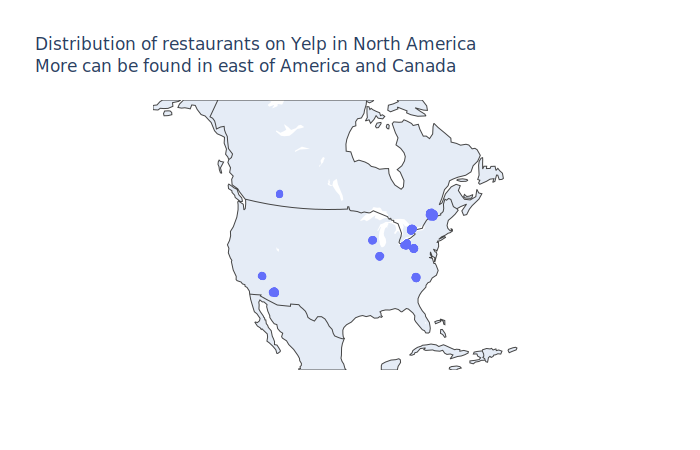

In [338]:
# Visualize the image result.
SVG(filename='result_images\\north_america_business.svg')

**Results:**

Description of Visualization:

Each point on the map represents a city. <br> City name and number of restaurants using Yelp in the city can be found by point to the point.

By observing the distribution of the cities, it is interesting to find there are two characters:
- Cities with Yelp applied gather in some regions.
- More cities in the east of the US and Canada use Yelp than in the west of the US and Canada.

According to the first observation, the development routine of Yelp can be known. When Yelp is used by a restaurant in a city, after other restaurants finding the impact of Yelp, then other restaurant will start using Yelp. After some time, business in surrounding cities will use Yelp to propaganda. This can explain why the cities use Yelp gather together. In this way, Yelp can only do propaganda in some big cities, and then satellite cities will be influenced by the big city. Therefore the scale of Yelp can be expanded in the area. 

The other interesting point is that Yelp is a company in San Francisco which locates in the west of the US, however, Yelp seems more popular in the east of both the US and Canada by the second observation. Therefore, further research will be done to figure out whether Yelp is more prevalent in the east than the west.

#### Compare Popularity of Yelp

**Method:**
1. Classify cities into two regions: west and east. The benchmark of classification is if the longitude of a city is less than $-100^{o}$, then the city is considered as western city, otherwise, the city will be considered as eastern city.
2. Count total number of cities in the west and east respectively.
3. Count total number of restaurants/shops in the west and east respectively.
4. Visualize those data by pie charts.

The dividing line of western and eastern should be Mississippi River actually. However I did not use this dividing line because the dataset still contain the business located in Canada and it is unnecessary to use Mississippi River as the dividing line. $-100^{o}$ longitude line can also divide western cities and eastern cities as required.

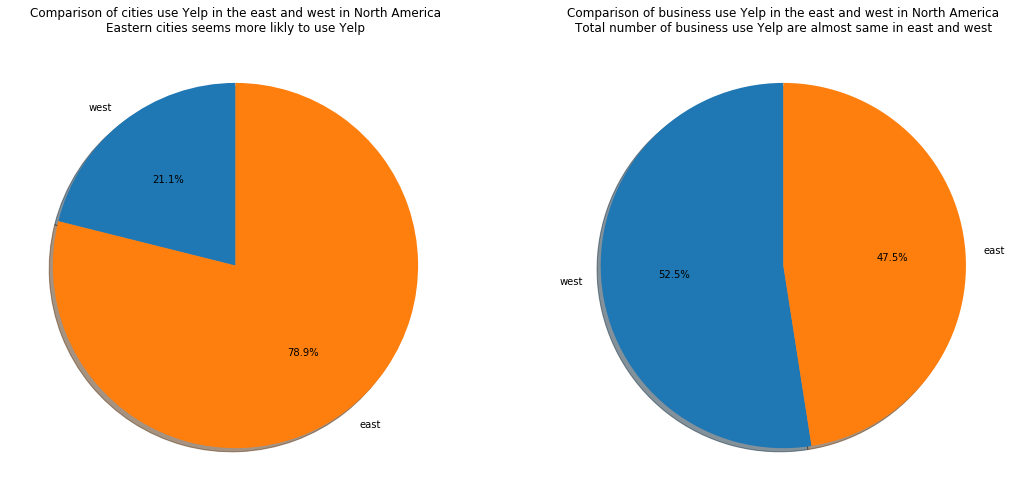

In [9]:
# Classify cities into east and west.
east_west = []
for i in range(len(loc_info_df)):
    if loc_info_df.longitude[i] < -100:
        east_west.append('west')
    else:
        east_west.append('east')

loc_info_df['region'] = east_west

west = loc_info_df[loc_info_df['region'] == 'west']
east = loc_info_df[loc_info_df['region'] == 'east']

# Count total number of cities in the west and east respectively.
total_cities_west = len(west)
total_cities_east = len(east)

# Count total number of restaurants in the west and east repectively.
west_total = sum(west['count'])
east_total = sum(east['count'])

# Plot pie chart.
labels = 'west', 'east'
fig, ax = plt.subplots(1, 2, figsize=(18, 9))

ax[0].set_title('Comparison of cities use Yelp in the east and west in North America\nEastern cities seems more likly to use Yelp')
ax[1].set_title('Comparison of business use Yelp in the east and west in North America\nTotal number of business use Yelp are almost same in east and west')

ax[0].pie([total_cities_west, total_cities_east], labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax[1].pie([west_total, east_total], labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

Explanation of Visualization:

The pie char in the left represents the comparison of the number of cities in the east of North America and the number of cities in the west. On the other hand, the pie chart in the right above indicates the proportion of restaurants in the east and west seperatly. 

1. Number of cities use Yelp in the east of North America is more than the number of cities in the west.
2. Number of business use Yelp in the east and west are almost same.

**Conclusion:**

From the observation, results can be gained:
1. More cities would like to use Yelp in the east than in the west although Yelp is located in San Francisco, Yelp is more prevalent in eastern part of North America.
2. Compare to the popularity of cities use Yelp, total number of restaurants in east and west are almost same, which means the density of restaurants use Yelp is higher in the west.

The conclusion is **Yelp is more popular among cities in the east than in the west while it is more prelavent in each of cities of the west than of the east**.

### What are the most frequent business categories overall?

#### Overview

**Method:**
1. Extract categories in each business.
2. For each category, count how many business in the category.
3. Visualize top 10 frequent business categories in bar plot.

Nevertheless, the limitation of this method is there are thousand number of categories in total, some categories may have relationship to each other, which means some categories may be the subset of other category or they may have a strong reltion. For example, business with category "Chinese" have huge probability of possession of category restaurants. In this way, some categories are hard to be extracted. However, the limitation does not influence the result of the most frequent business too much.

In [10]:
# Extract each category from every business categories fields and count
# how many business are related to this category.
def extract_categories(df):
    categories = {}
    for i in range(len(df)):
        if df.categories[i] is np.nan:
            continue
        category = df.categories[i].strip().split(',')
        for cate in category:
            cate = cate.strip()
            if cate not in categories:
                categories[cate] = 0
            categories[cate] += 1

    return categories

categories = extract_categories(business)

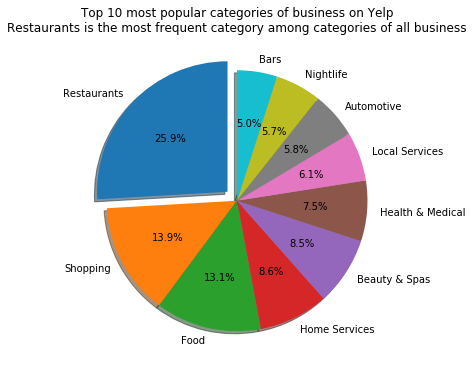

In [11]:
# Find top 10 categories in among all business,
categories_df = pd.DataFrame.from_dict({'category': list(categories.keys()), 'count': list(categories.values())})
sorted_categories_df = categories_df.sort_values(by=['count'], ascending=False).reset_index(drop=True)
categories_top_10 = sorted_categories_df[:10]

# Plot pie chart.
labels = categories_top_10.category
explode = [0.1]
explode.extend([0 for i in range(9)])

plt.figure(figsize=(6, 6))
plt.pie(categories_top_10['count'], labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, explode=explode)
plt.title('Top 10 most popular categories of business on Yelp\nRestaurants is the most frequent category among categories of all business')

plt.show()

**Conclusion**

The bar plot above indicates the top 10 categories in among all business in North America registered on Yelp. There are 59371 business are classified as restaurants which is also the most frequent business. 

According to this result, preference of public can be found which is related to **eating and shopping**. Therefore, the hypothesis can be come up with that people are fond of spending their spare time on delicious food and shopping. 

#### Which food do public prefer? 

According to the result above, restaurants is the most frequent business registered on Yelp which implies the huge demands of public, therefore it is necessary to do more research into which kind food do public prefer.

**Method:**
1. Filter restaurants from all business.
2. Count each categories form restaurants.
3. Visualize the result by bar plot.

Limitation of this method is similar to the last one. Categories are complex and messy, it is easy to have relation between one or more categories. For example bars often represents nightlife, cages may indicate Coffee & Tea, in this way, some also may be missed which means some restaurants are counted as cafe but not coffee & tea. This may have influence on our result.

In [12]:
# Delete rows with np.nan in categories column.
business_categories_without_na = business[business.categories.isna() == False].reset_index(drop=True)

# Find those business are restaurants
restaurants = business_categories_without_na[business_categories_without_na['categories'].apply(lambda x: 'Restaurants' in x)].reset_index(drop=True)
restaurants_categories = extract_categories(restaurants)

# Delete repeated or unnecessary keys in restaurants_categories
del restaurants_categories['Restaurants']
del restaurants_categories['Food']
del restaurants_categories['Nightlife']

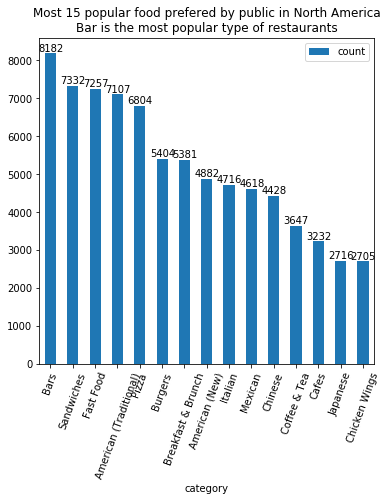

In [13]:
# Find top 15 popupar food prefered by public.
restaurants_categories_df = pd.DataFrame.from_dict({'category': list(restaurants_categories.keys()), 
                                                    'count': list(restaurants_categories.values())})
sorted_restaurants_df = restaurants_categories_df.sort_values(by=['count'], ascending=False)
top_15_restaurants = sorted_restaurants_df[:15].reset_index(drop=True)

# Plot the bar plot.
top_15_restaurants.plot.bar(x='category', y='count', rot=70, figsize=(6, 6))
plt.title('Most 15 popular food prefered by public in North America\nBar is the most popular type of restaurants')
for i in range(len(top_15_restaurants)):
    plt.text(i - 0.55, top_15_restaurants['count'][i] + 50, s=str(top_15_restaurants['count'][i]))
plt.show()

**Conclusion**

Based on the bar plot above, it is not hard to find there are 8182 bars on Yelp in total which is the most prevalent type of restaurant. This phenomenon implies a high demand for bars of people. 

In addition, sandwiches and fast food take the second and third places respectively. Since most data in the dataset are belongs to the US, the result indicates that American people prefer sandwiches and fast food a lot. Therefore, a new American restaurant had better to choose to provide public more sandwiches and fast food which are the most popular food in the US.

### What types of establishments tend to have bike parking?

**Method:**
1. Extract the business with information of bike parking.
2. Classify business with bike parking and without bike parking into two dataframes.(none bike parking is considered as business without bike parking because it can be interpreted as there is none bike parking of the business and those business without bike parking information are disgarded)
3. Find the number of each business in each category in each dataframe.
4. Define parking coefficient of a category: parking_coefficient = $\frac{\frac{number\ of\ category\ with\ bike\ parking}{number\ of\ business\ with\ bike\ parking}}{\frac{number\ of\ category\ without\ bike\ parking}{number\ of\ business\ without\ bike\ parking}}$
5. Visualze the result.

**Explanation to the method:**

It is rational to use this method to measure the trend to have bike parking for a category because it is easy to come up with the idea to compare the number of the bussiness in the category with bike parking and without bike parking. 

However the base is different which means the total number of business with bike parking and without bike parking are different. Thus the total number of business without bike parking and with bike parking divide the number of business with or without bike parking in the category respectively which is to standardize the number of business in the category. 

Finally the division of these two values can represent the tendency of the business in the category is whether with bike parking or without bike parking.

Therefore, 1 can be used as the dividing point. If the coefficient is greater than 1, the trend will be providing bike parking and vice versa. The higher result represents the type of establishment is more likely to have bike parking area.

**Advantage:**

There is another method to define this coefficient: $\frac{number\ of\ category\ with\ bike\ parking}{number\ of\ category\ without\ bike\ parking}$. It is easy to understand that the higher the coefficient is, the high probability that the business providing bike parking. However, this coefficient can only be used to compare which business is more likely to have bike parking. If there is only one category, this method cannot show the trend of providing bike parking. 

Therefore the advantage of this method is we can use 1 as the dividing point which provides us with a benchmark to measure the trend of a category of business providing bike parking. Even if there is only one category, this coefficient can also show us the tendency. 

**Limitation:**
- Information of several categories is limited and the denominator of the formula above sometimes can be 0 which means all business in such category are with bike parking and vice versa. In this way, those categories with this phenomenon will be analysised seperately.
- The range of this coefficient is [0, +$\infty$) which is not symmetic. Therefore it is hard to show the extent of tendency of providing bike sharing. If use subtraction to subsitute division which solve this problem. However, the result of subtaction is not easy to be visualized because the coefficient of each category is extremely near.

In [14]:
business_attributes_without_na = business[business.attributes.isna() == False]

# Find business with information about bike parking.
bike_parking = business_attributes_without_na[business_attributes_without_na['attributes'].apply(lambda x: 'BikeParking' in x)].reset_index(drop=True)

In [15]:
# Find business with bike parking.
allow_bike_parking = bike_parking[bike_parking['attributes'].apply(lambda x: x['BikeParking'] == 'True')].reset_index(drop=True)
allow_bike_categories = extract_categories(allow_bike_parking)

In [16]:
disallow_bike_parking1 = bike_parking[bike_parking['attributes'].apply(lambda x: x['BikeParking'] == 'False')]
disallow_bike_parking2 = bike_parking[bike_parking['attributes'].apply(lambda x: x['BikeParking'] == 'None')]
disallow_bike_parking = pd.concat([disallow_bike_parking1, disallow_bike_parking2]).reset_index(drop=True)
disallow_bike_categories = extract_categories(disallow_bike_parking)

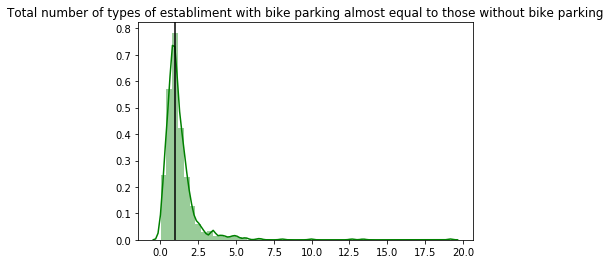

In [17]:
num_allow = len(allow_bike_parking)
num_disallow = len(disallow_bike_parking)

all_allow_bike_parking = {}
all_disallow_bike_parking = {}

categories_percentage = {}
for category in allow_bike_categories:
    # Seperate business with bike parking categories in small number.
    if category not in disallow_bike_categories:
        all_allow_bike_parking[category] = allow_bike_categories[category]
        continue

    # Calculate the coefficient.
    categories_percentage[category] = (allow_bike_categories[category] / num_allow) / (disallow_bike_categories[category] / num_disallow)

# Seperate business without bike parking categories in small number.
for category in disallow_bike_categories:
    if category not in allow_bike_categories:
        all_disallow_bike_parking[category] = disallow_bike_categories[category]

# Visualize the result.
plt.title('Total number of types of establiment with bike parking almost equal to those without bike parking')
# plt.ylabel('Number of categories')
# plt.xlabel('Coefficient of bike parking')
# plt.hist(np.array(list(categories_percentage.values())), bins=100)
ax = sns.distplot(np.array(list(categories_percentage.values())), color='green')
plt.axvline(1, color='black')
plt.show()

According to this histogram, we know the total number of business with bike parking almost equals to the number of business without bike parking area.


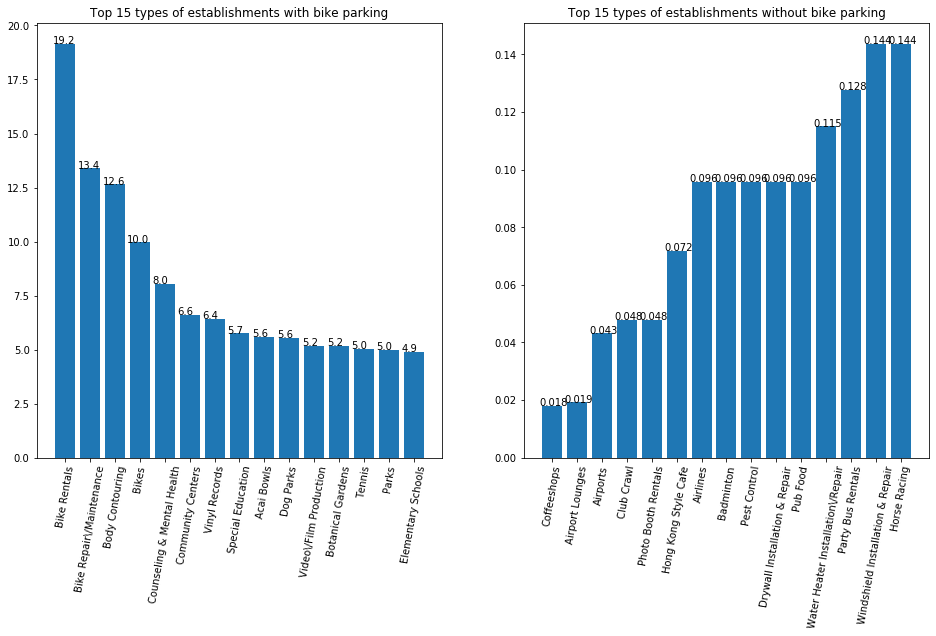

In [18]:
# Find top 15 categories with bike parking and without bike parking.
categories_percentage_df = pd.DataFrame.from_dict({'category': list(categories_percentage.keys()), 'coefficient': list(categories_percentage.values())})
categories_percentage_sorted_ascending = categories_percentage_df.sort_values(by=['coefficient'], ascending=True).reset_index(drop=True)
categories_percentage_sorted_descending = categories_percentage_df.sort_values(by=['coefficient'], ascending=False).reset_index(drop=True)
allow_bike_parking_trend = categories_percentage_sorted_descending[:15]
disallow_bike_parking_trend = categories_percentage_sorted_ascending[:15]

# Visualize the result in bar.
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].bar(x=allow_bike_parking_trend['category'], height=allow_bike_parking_trend['coefficient'])
ax[1].bar(x=disallow_bike_parking_trend['category'], height=disallow_bike_parking_trend['coefficient'])

# Set title for subplots.
ax[0].set_title('Top 15 types of establishments with bike parking')
ax[1].set_title('Top 15 types of establishments without bike parking')

# Rotate the x-axis.
for i in range(len(ax)):
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(80)

# Label the coefficient.
for i in range(len(allow_bike_parking_trend)):
    ax[0].text(i - 0.5, allow_bike_parking_trend['coefficient'][i], '{0:.1f}'.format(allow_bike_parking_trend['coefficient'][i]))

for i in range(len(disallow_bike_parking_trend)):
    ax[1].text(i - 0.5, disallow_bike_parking_trend['coefficient'][i], '{0:.3f}'.format(disallow_bike_parking_trend['coefficient'][i]))


**Conclusion:**

Business related to bikes are most likely to have bike parking are while coffee shops and places related to airports are the places most impossible to provide bike parking area which makes a lot sense.

The type of business are all with and without parking area are analysised as following.

There are two possibilities for this phenomenon:
- The number of business of that type is extremely small, for this case, the information can be discarded because the result wll be meaningless.
- There are a lot of sample, however, all the sample in such type have the same attitude on bike parking. In this case, the result need to be considered.

However, after analysising these two datasets, the largest number of business in the all business with bike parking dataset is 14 which are baseball fields, while the largest number in the other dataset is 3 which are airport shuttles. Compared to the total business with bike parking information dataset, these numbers are too small which means these business can be discarded because even if analysis them, the result cannot be accurate enough.

### An article recently claimed that having more yelp reviews lead to a higher rating, and hence increased sales. Do the data support this claim?

#### Overview

**Method:**
1. Do linear regression of review_count and stars.
2. Visualize the resualt in box plot and do the linear regression between stars and review_counts.

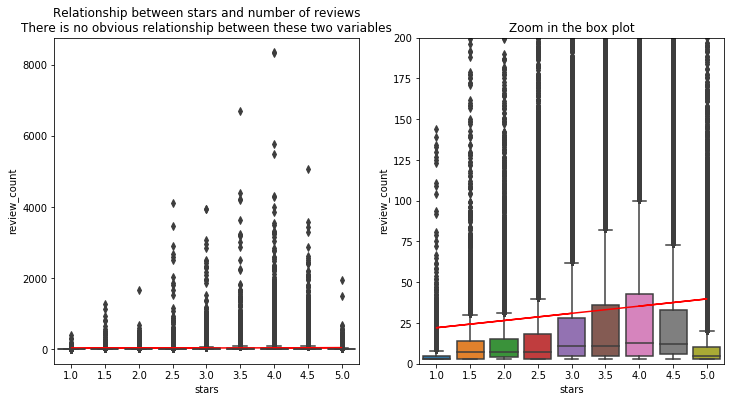

In [312]:
# Do linear regression between stars and review_count
linear_regressor = LinearRegression()
X = business.stars.values.reshape(-1, 1)
Y = business.review_count.values.reshape(-1, 1)
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

# Visualize the result.
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(x='stars', y='review_count', data=business, ax=axs[0])

axs[0].plot(2 * X - 2, Y_pred, color='red')
axs[0].set_title('Relationship between stars and number of reviews\nThere is no obvious relationship between these two variables')

sns.boxplot(x='stars', y='review_count', data=business, ax=axs[1])
axs[1].set_ylim(0, 200)
axs[1].plot(2 * X - 2, Y_pred, color='red')
axs[1].set_title('Zoom in the box plot')
plt.show()

In [313]:
print('The correlation coefficient is {0:.2f}'.format(np.corrcoef(business['stars'], business['review_count'])[0][1]))

The correlation coefficient is 0.04


**Conclusion:**
According to the boxplot above, the median of each star category have no big difference. By the result of linear regression, **there is no obvious relation between stars and number of reviews.** Therefore, more reviews of a business may imply higher rate it can obtain.  

#### Relationship between number of Yelp reviews and rating for restaurants

According to all of the business on Yelp, **more reviews does not imply higher rates**. However, it is still necessary to do more research into the same question but narrow the range of business to restaurants. The previous result indicates public have most demand for restaurant resources because of high quantity of restaurants on Yelp. Thus, this research may provide a new method to predict the quality of a restaurant.

**Methods:**
1. Do linear regression between review_count and stars.
2. Visualize the result by boxplot.
3. Calculate correlation coefficient.

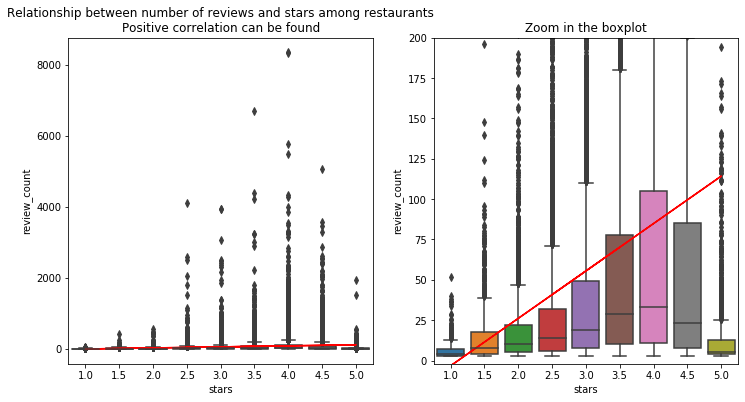

In [325]:
# Do linear regression between stars and review_count
linear_regressor = LinearRegression()
X = restaurants.stars.values.reshape(-1, 1)
Y = restaurants.review_count.values.reshape(-1, 1)
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

# Visualize the result.
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(x='stars', y='review_count', data=restaurants, ax=axs[0])
axs[0].plot(2 * X - 2, Y_pred, color='red')
axs[0].set_title('Relationship between number of reviews and stars among restaurants\nPositive correlation can be found')

sns.boxplot(x='stars', y='review_count', data=restaurants, ax=axs[1])
axs[1].plot(2 * X - 2, Y_pred, color='red')
axs[1].set_ylim(-2, 200)
axs[1].set_title('Zoom in the boxplot')

plt.show()

In [24]:
print('The correlation coefficient is {0:.2f}'.format(np.corrcoef(restaurants['stars'], restaurants['review_count'])[0][1]))

The correlation coefficient is 0.13


**Conclusion:**

By observing the boxplot and the line of linear regression, **a positive correlation can be found between number of reviews and stars among restaurants dataset**. 

To guarantee the existence of positive correlation, correlation coeffcient is calculated by 
<center>$r = \frac{1}{n}\Sigma_{i=1}^{n}(\frac{X_i - \bar{X}}{\sigma_X})(\frac{Y_i - \bar{Y}}{\sigma_Y})$</center>
Then the correlation coefficient is 0.13 which means there is a weak positive relation between review_count and stars these two variables in the restaurants dataset.

This results is quite amazing compared to the last result. Positive relation between number of reviews and rating cannot be found when the dataset contains all business while can be found when the dataset only contains restaurants. Therefore the statement in the article is partially true beacause the phenomenon exists when for business relate to restaurants. In this way, public also can select restaurant not only by the stars but also by the number of feedback of other customers.

**Discussion:**

I did not remove any outliers in this part because there really exists business with more than 8000 reviews which is true. Therefore, there is not any reason to remove outliers when doing data analysis. However, there may be some restaurants may hire "paid reviewers" which represents those people given money by business write positive comments. In this way, the number of reviews may increase a lot while it can still have a low star rating.

Another concern on this question is although we can observe a positive relationship between number of reviews and star ratings, there is no data for us to analysis whether this can increase the profit for business. Therefore, the further research should be done if we can have the dataset which provide us with the profit information for each business. After we do the further research, the most accurate conclusion can be gained.

##  GTA businesses

### Data Cleaning

Business only in GTA(Great Toronto Area) will be analysised in this part, then before analysis, data need to be cleaned which means business in GTA need to be selected and those business are not in GTA need to be dropped.

**Methods:**
1. Filter business locate in Ontario.
2. According to the postal_code, filter out business in GTA.

**Explanation:**
This method is reasonable because according to the [Forward Sortation Area](https://www.ic.gc.ca/eic/site/bsf-osb.nsf/eng/br03396.html), cities in GTA are with postal code started with "M" or "L". Therefore, business in GTA can be selected in this way.

In [25]:
# Select business in Ontario.
ontario = business[business['state'] == 'ON'].reset_index(drop=True)

# Since the postal code of business in GTA starts with "M" or "L", then use this to filter the business in GTA. 
index = []
for i in range(len(ontario)):
    # print(i, ontario.postal_code[i])
    if len(ontario.postal_code[i]) < 1:
        index.append(False)
        continue
    if ontario.postal_code[i][0] == 'M' or ontario.postal_code[i][0] == 'L':
        index.append(True)
    else:
        index.append(False)

gta_business = ontario[index].reset_index(drop=True)

In [340]:
# Run this code to generate visualization
# fig = px.scatter_mapbox(gta_business, lat="latitude", lon="longitude", hover_name="name", hover_data=['stars'],
#                         color_discrete_sequence=["purple"], zoom=7, height=300, opacity=0.05)
# fig.update_layout(mapbox_style="open-street-map")
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()


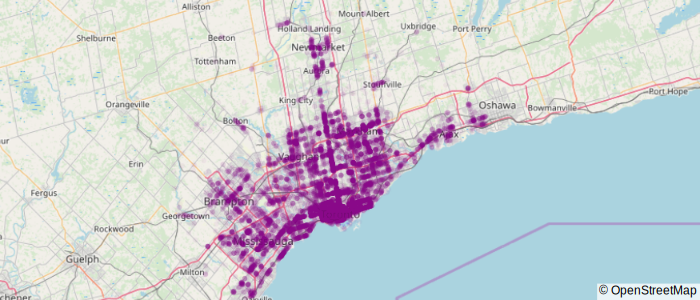

In [342]:
# Show visualization
SVG(filename='result_images' + os.sep + 'GTA_business.svg')

The plot above indicates all business in the Great Toronto Area, each purple point represents a busines. Then the area with more business will be shown in a darker color on the map above. We can see the density of business is the highest in downtown area and there are a lot of business on Yonge street.

### What are the most frequent business categories?

#### Overview

**Methods:**
The method used here is similar to the method in the last part where the most frequent category is found for all business on Yelp. 
1. Discard those business which did not declare the categories.
2. Find the top 10 popular categories from the dataset.
3. Visualize the results by bar plot.

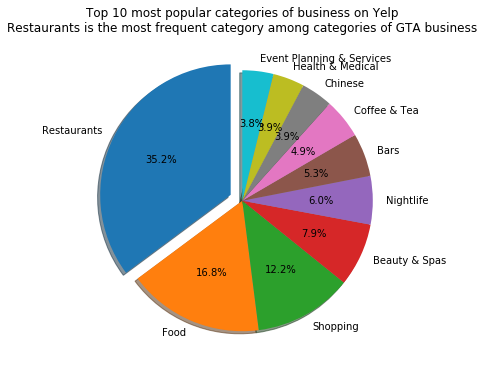

In [27]:
gta_business_without_na = gta_business[gta_business.categories.isna() == False].reset_index(drop=True)
gta_business_categories = extract_categories(gta_business_without_na)

gta_business_categories_df = pd.DataFrame.from_dict({'categories': list(gta_business_categories.keys()), 'count': list(gta_business_categories.values())})
sorted_gta_business_categories = gta_business_categories_df.sort_values(by=['count'], ascending=False).reset_index(drop=True)

gta_business_top_10_categories = sorted_gta_business_categories[:10]
# gta_business_top_10_categories.plot.bar(x='categories', y='count', rot=60, color='green')

# for i in range(len(gta_business_top_10_categories)):
#     plt.text(i - 0.3, gta_business_top_10_categories['count'][i] + 100, str(gta_business_top_10_categories['count'][i]))

# Plot pie chart.
labels = gta_business_top_10_categories.categories
explode = [0.1]
explode.extend([0 for i in range(9)])

plt.figure(figsize=(6, 6))
plt.pie(gta_business_top_10_categories['count'], labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, explode=explode)
plt.title('Top 10 most popular categories of business on Yelp\nRestaurants is the most frequent category among categories of GTA business')

plt.show()

**Conclution:**
1. Compared to the categories among all business, the same point is restaurants is still the most prevalent category on Yelp.
2. The different point is public in **GTA seems to have a larger demand for restaurants**. The number of restaurants is nearly 3 times of the number of shopping while this is nearly 2 times in all business analysis. In addition, there are only 4 categories which is not related to eating in top 10 GTA business while the number is 6 among all business.

Therefore, restaurants data will be done further research to find the difference of flavors between people in GTA and whole North America.

#### Most frequent restaurant categories in GTA

**Methods:**
1. Select restaurants from all gta business.
2. Extract each catefories from each restaurants.
3. Visualize and analysis the result.

In [28]:
# Delete rows with np.nan in categories column.
gta_business_categories_without_na = gta_business[gta_business.categories.isna() == False].reset_index(drop=True)

# Find those business are restaurants
gta_restaurants = gta_business_categories_without_na[gta_business_categories_without_na['categories'].apply(lambda x: 'Restaurants' in x)].reset_index(drop=True)
gta_restaurants_categories = extract_categories(gta_restaurants)

# Delete repeated or unnecessary keys in restaurants_categories
del gta_restaurants_categories['Restaurants']
del gta_restaurants_categories['Food']
del gta_restaurants_categories['Nightlife']

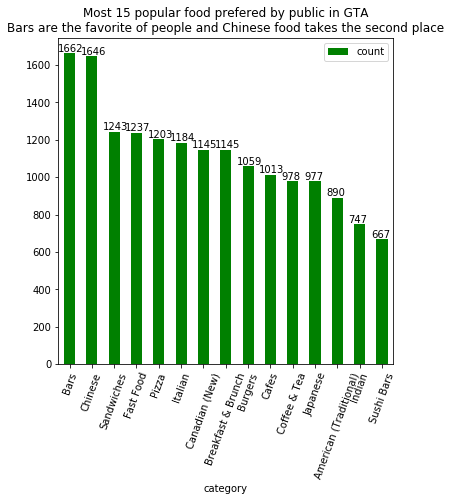

In [55]:
# Find top 15 popupar food prefered by public.
gta_restaurants_categories_df = pd.DataFrame.from_dict({'category': list(gta_restaurants_categories.keys()), 
                                                    'count': list(gta_restaurants_categories.values())})
gta_sorted_restaurants_df = gta_restaurants_categories_df.sort_values(by=['count'], ascending=False)
gta_top_15_restaurants = gta_sorted_restaurants_df[:15].reset_index(drop=True)

# Plot the bar plot.
gta_top_15_restaurants.plot.bar(x='category', y='count', rot=70, figsize=(6, 6), color='green')
plt.title('Most 15 popular food prefered by public in GTA\nBars are the favorite of people and Chinese food takes the second place')
for i in range(len(gta_top_15_restaurants)):
    plt.text(i - 0.5, gta_top_15_restaurants['count'][i] + 10, s=str(gta_top_15_restaurants['count'][i]))
plt.show()

**Results:**
This result is interesting, the bar plot can be interpreted as following:
1. Compared to the business among all North America, bars is still the most frequent category in GTA.
2. The different point is that rather than sandwiches, Chinese food take the second place. This result implies that **Chinese food is more prefered in GTA and the density of Chinese people in GTA is much higher than in whole North America**. According to this distribution of restaurants, density of each ethnicities also can be predicated in the area.

The correctness of this result can be partially proven by the rank of tranditional American food among business and the rank of new Canadian food in GTA.

**Discussion:**

It is hard to find the most accurate category for each restaurant. For example, there may be an Italian food restaurant is only labeled as restaurant but not as Italian restaurant. In this way, the number of restaurants in each category maybe a little bit lower than the real value. 

### What are the top franchises in the city?

In this part, top 10 popular franchies in the city will be figured out. However, some fanchies in the city are with different names but they are actually same. Therefore, some data cleaning will be done as following method.

**Method:**
There are two benchmarks to defind top framchises: popularity(density i.e. number of the franchises in GTA) and number of reviews. It is necessary to analysis this question in these two respects seperately and analysis the relationship between these two benchmarks.

1. Find top 20 popular franchies in the city.
2. Find the proper name by using fuzzywuzzy
3. Clean the name for these franchies manully because this will not have big impact on the final result.
4. Find top 10 popular franchies in the city.

In [30]:
gta_business.name = gta_business.name.apply(lambda x: x.lower())

# Clean the business name and it is finded by fuzzywuzzy with WRatio greater than or equal to 90.
gta_business.name = gta_business.name.replace(['tim horton\'s', 'tim horton', 'tim hortons'], 'tim hortons')
gta_business.name = gta_business.name.replace(['maple leaf gardens lcbo', 'lcbo - chinatown', 'lcbo - danforth and greenwood', 'lcbo - dundas and jane', 'lcbo markham', 'lcbo - st. lawrence market', 'lcbo maple leaf square', 'lcbo - cabbagetown lcbo', 'lcbo - bloor west village', 'lcbo - gerrard and pape', 'lcbo - queen and coxwell', 'lcbo - dundas and dovercourt', 'lcbo - queen and dufferin', 'lcbo - eglinton and avenue', 'lcbo - leaside', 'lcbo - yonge eglinton centre'], 'lcbo')
gta_business.name = gta_business.name.replace(['mcdonalds', 'mcdonald'], 'mcdonald\'s')
gta_business.name = gta_business.name.replace(['the second cup', 'second cup at empress walk', 'second cup coffee'], 'second cup')
gta_business.name = gta_business.name.replace(['shoppers drug mart steeple hill', 'shopper\'s drug mart'], 'shoppers drug mart')
gta_business.name = gta_business.name.replace(['dominos pizza', 'dominos\' pizza'], 'domino\'s pizza')
gta_business.name = gta_business.name.replace(['popeyes louisiana kitchen'], 'popeye\'s louisiana kitchen')
gta_business.name = gta_business.name.replace(['goodlife fitness - toronto bloor park', 'goodlife fitness - toronto bell trinity centre'], 'goodlife fitness')



In [31]:
# Initialize two dictionaries.
gta_franchises_reviews = {}
gta_franchises_count = {}

for i in range(len(gta_business)):
    if gta_business.name[i] not in gta_franchises_reviews:
        gta_franchises_reviews[gta_business.name[i]] = 0
    if gta_business.name[i] not in gta_franchises_count:
        gta_franchises_count[gta_business.name[i]] = 0
    
    gta_franchises_reviews[gta_business.name[i]] += gta_business.review_count[i]
    gta_franchises_count[gta_business.name[i]] += 1

gta_franchies_count_df = pd.DataFrame({'franchies': list(gta_franchises_count.keys()), 'count': list(gta_franchises_count.values())})
gta_franchies_reviews_df = pd.DataFrame({'franchies': list(gta_franchises_reviews.keys()), 'reviews': list(gta_franchises_reviews.values())})

In [32]:
gta_franchies_count_sorted = gta_franchies_count_df.sort_values(by=['count'], ascending=False).reset_index(drop=True)
gta_franchies_reviews_sorted = gta_franchies_reviews_df.sort_values(by=['reviews'], ascending=False).reset_index(drop=True)

top_10_franchies_count = gta_franchies_count_sorted[:10]
top_10_franchies_reviews = gta_franchies_reviews_sorted[:10]

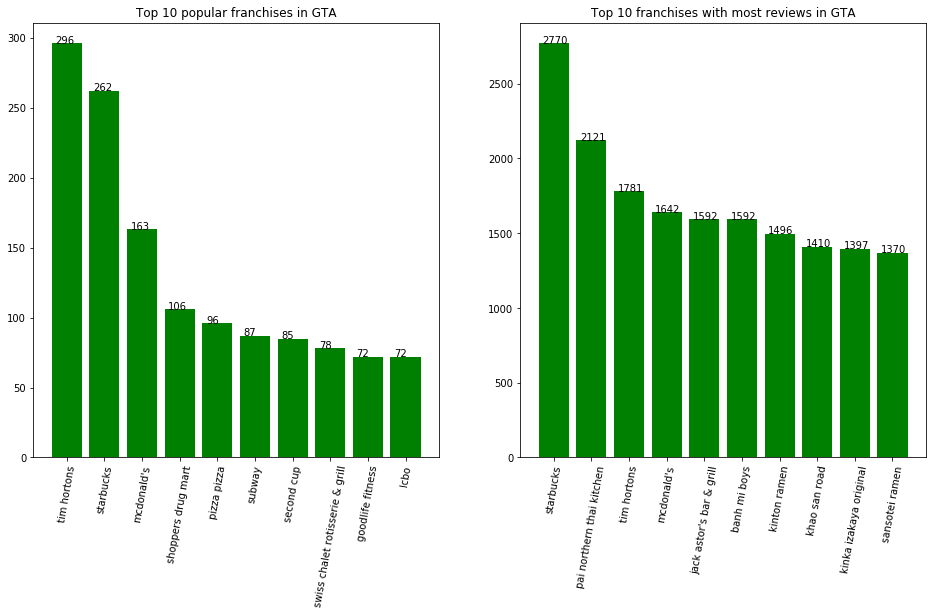

In [281]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].bar(x=top_10_franchies_count['franchies'], height=top_10_franchies_count['count'], color='green')
ax[1].bar(x=top_10_franchies_reviews['franchies'], height=top_10_franchies_reviews['reviews'], color='green')

ax[0].set_title('Top 10 popular franchises in GTA')
ax[1].set_title('Top 10 franchises with most reviews in GTA')

# Rotate the x-axis.
for i in range(len(ax)):
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(80)

for i in range(len(top_10_franchies_count)):
    ax[0].text(i - 0.3, top_10_franchies_count['count'][i], '{}'.format(top_10_franchies_count['count'][i]))

for i in range(len(top_10_franchies_reviews)):
    ax[1].text(i - 0.3, top_10_franchies_reviews['reviews'][i], '{}'.format(top_10_franchies_reviews['reviews'][i]))


**Result:**
1. Tim Hortons is the most popular franchises in GTA and Starbucks take the second price.
2. Goodlife Fitness is the franchise with largest density in GTA which is not related to food & restaurant.
3. Starbucks is the franchises with most reviews.
4. It is interesting to find that more popular franchises does not mean more reviews of the franchises and more reviews does not mean the franchises is popular.

### Does business location play an important role in reviews?

#### Relation between total reviews and location

**Methods:**

There are two main parts in GTA: Metropolitan Toronto and surrounding area of GTA. In order to seperate these two areas based on [Forward Sortation Area](https://www.ic.gc.ca/eic/site/bsf-osb.nsf/eng/br03396.html), business with postal codes start with M are the business located at the Metropolitan Toronto while postal codes start with L are in surrounding area of GTA.

First, total number of reviews in these two areas are calculated respectively and it is visualized in a donut pie chart as following:

In [34]:
gta_business.city = gta_business.city.apply(lambda x: x.lower())
gta_business['text'] = gta_business.name + ' with reviews: ' + gta_business.review_count.apply(lambda x: str(x))

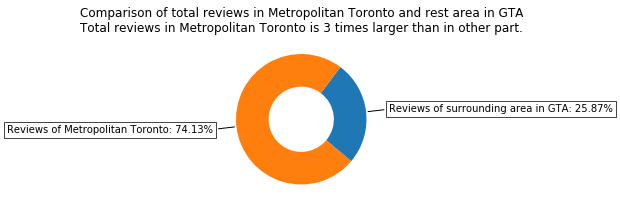

<Figure size 864x864 with 0 Axes>

In [35]:
L_postal_business = gta_business[gta_business['postal_code'].apply(lambda x: x[0] == 'L')]
M_postal_business = gta_business[gta_business['postal_code'].apply(lambda x: x[0] == 'M')]

L_total_reviews = sum(L_postal_business.review_count)
M_total_reviews = sum(M_postal_business.review_count)

mean_L_reviews = L_total_reviews / len(L_postal_business)
mean_M_reviews = M_total_reviews / len(M_postal_business)

# Code from matplotlib document:
# https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = ['Reviews of surrounding area in GTA: {0:.2f}%'.format(L_total_reviews / (L_total_reviews + M_total_reviews) * 100),
          'Reviews of Metropolitan Toronto: {0:.2f}%'.format(M_total_reviews / (L_total_reviews + M_total_reviews) * 100)]

data = [L_total_reviews / (L_total_reviews + M_total_reviews), M_total_reviews / (L_total_reviews + M_total_reviews)]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title('Comparison of total reviews in Metropolitan Toronto and rest area in GTA\nTotal reviews in Metropolitan Toronto is 3 times larger than in other part.')
plt.figure(figsize=(12, 12))
plt.show()

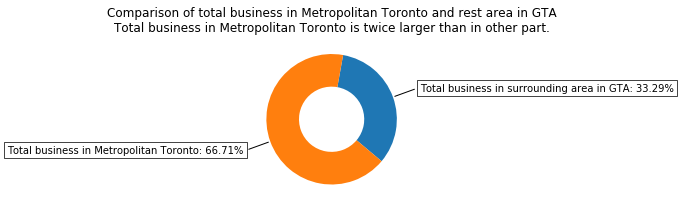

<Figure size 864x864 with 0 Axes>

In [36]:
# Code from matplotlib document:
# https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = ['Total business in surrounding area in GTA: {0:.2f}%'.format(len(L_postal_business) / (len(L_postal_business) + len(M_postal_business)) * 100),
          'Total business in Metropolitan Toronto: {0:.2f}%'.format(len(M_postal_business) / (len(L_postal_business) + len(M_postal_business)) * 100)]

data = [len(L_postal_business), len(M_postal_business)]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title('Comparison of total business in Metropolitan Toronto and rest area in GTA\nTotal business in Metropolitan Toronto is twice larger than in other part.')
plt.figure(figsize=(12, 12))
plt.show()

**Conclution:**

Most reviews are given for establishments locate in Metropolitan Toronto which is almost 3 times larger than the number of reviews given to business in the surrounding area in GTA. The initial conclusion can be gained that business in Metropolitan Toronto seems to have more reviews.

However, the main limitation of this method is that the total number of business in Metropolitan Toronto and surrounding area of GTA is different, which may have negative influence on the result. In the second pie chart above, business in Metropolitan Toronto is twice larger than business in surrounding area of GTA.

Therefore, the mean and median of reviews in each area will be analysised which will provide a more accurate result.

#### Relation between mean/median reviews and business location

**Method:**

The median and mean value of reviews in Metropolitan Toronto and surrounding area are calculated seperately. Then the results are visalized in the bar plot after which the result can be concluded. 

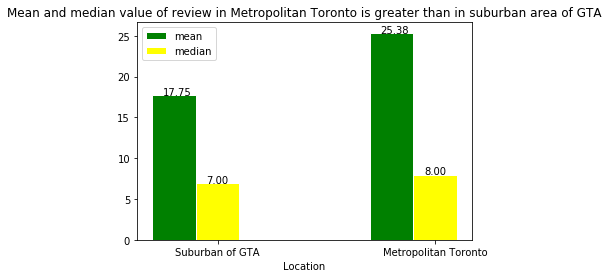

In [37]:
# Code source: https://python-graph-gallery.com/11-grouped-barplot/
# set width of bar
barWidth = 0.2
 
# set height of bar
bars1 = [mean_L_reviews, mean_M_reviews]
bars2 = [L_postal_business.review_count.quantile(0.5), M_postal_business.review_count.quantile(0.5)]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, bars1, color='green', width=barWidth, edgecolor='white', label='mean')
plt.bar(r2, bars2, color='yellow', width=barWidth, edgecolor='white', label='median')

# Add xticks on the middle of the group bars
plt.xlabel('Location')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Suburban of GTA', 'Metropolitan Toronto'])
 
# Create legend & Show graphic
plt.legend()

# Text the value of each mean and median.
for i in range(len(bars1)):
    plt.text(r1[i] - 0.05, bars1[i], '{0:.2f}'.format(bars1[i]))
    plt.text(r2[i] - 0.05, bars2[i], '{0:.2f}'.format(bars2[i]))
    
plt.title('Mean and median value of review in Metropolitan Toronto is greater than in suburban area of GTA')
plt.show()


**Conclusion:**

Based on the visualization above, the conclusion is **business in Metropolitan Toronto are more likely to gain reviews.**

In the last part, total reviews for business in Metropolitan Toronto gained much more reviews than those in suburban of GTA and in this part. 

In this part, each business in Metropolitan Toronto can get 25.38 reviews while the expectation of reviews of business in suburban is 17.75. The median for business in central Toronto is also greater than those in the surrounding. Therefore, location is important to obtain more reviews. In this way, if a business is eager to have better future, it had better develop in central Toronto but is not just limited in the suburban of GTA.

#### How to select location for a newly opened business? 

It is interesting to find that the business locate in central Toronto tend to gain more reviews which may indicate more profit. However, the cost of a newly opened business locates in the central Toronto is also extremely high. Therefore, it is interesting to find whether there any other place can receive reviews but not in downtown Toronto.

**Method:**
1. Find top 1000 business in GTA sorted by number of reviews received.
2. Visualize the distribution of those business on the map.

In [345]:
# Run following code to generate visualization.
# sorted_review_gta_business = gta_business.sort_values(by=['review_count'], ascending=False).reset_index(drop=True)
# top_500_gta_business_review = sorted_review_gta_business[:1000]
# fig = px.scatter_mapbox(top_500_gta_business_review, lat="latitude", lon="longitude", hover_name="name", hover_data=['review_count'],
#                         color_discrete_sequence=["green"], zoom=10, height=300, opacity=0.5)
# fig.update_layout(mapbox_style="open-street-map")
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

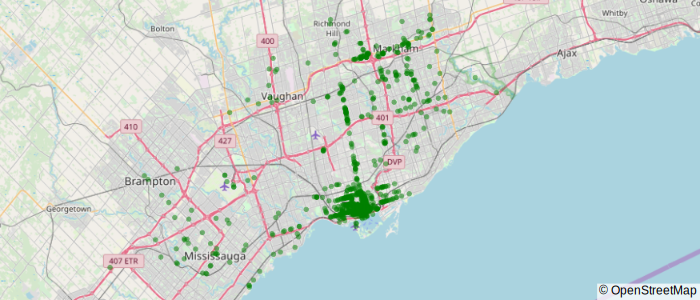

In [344]:
SVG('result_images' + os.sep + 'reviews_count.svg')

**Conclusion**

According to the distribution of top 1000 business on the map, there are some concentrations areas: downtown Toronto, Youge street and Markham. In addtion, some area with lower density can be find in Missisauga and Vaughan. Therefore we can conclude that a newly opened restaurant can locate on Yonge street or Markham rather than just in downtown Toronto. In addition, Vaugahn and Mississauge are also good choice.

**Discussion**

The limitation of this method is the total number of business at central Toronto is larger than the number of business in other areas. This plot can only show most of top 1000 business locate at central Toronto but it does not indicate that the establishment at central Toronto are easier to get a higher star rating.

### Is it true that for every Tim Hortons in the GTA there is a Starbucks nearby?

**Method:**
1. Visualize the plot Tim Hortons and Starbucks on GTA map directly, which provides a overview result.
2. For each Tim Hortons, find the nearest Starbucks and record the distance. For each Starbucks, find the nearest Tim Hortons and recode the distance.
3. Visualize the result in boxplot and compare the distances.

In [56]:
tim_hortons = gta_business[gta_business.name == 'tim hortons'].reset_index(drop=True)
starbucks = gta_business[gta_business.name =='starbucks'].reset_index(drop=True)
second_cup = gta_business[gta_business.name == 'second cup'].reset_index(drop=True)

In [346]:
# Run following code to generate visualization.
# fig = go.Figure(data=[
#         go.Scattergeo(lon = tim_hortons['longitude'],
#                       lat = tim_hortons['latitude'],
#                       mode = 'markers',
#                       marker = dict(color = 'red'), 
#                       legendgroup='Tim Hortons', 
#                       showlegend=True, 
#                       name='Tim Hortons', opacity=0.5), 
#         go.Scattergeo(lon = starbucks['longitude'], 
#                       lat=starbucks['latitude'], 
#                       mode='markers', 
#                       marker=dict(color='green'), 
#                       legendgroup='Starbucks', 
#                       showlegend=True, 
#                       name='Starbucks', opacity=0.7)])

# fig.update_layout(
#         title = 'Distribution of Tim Hortons and Starbucks in GTA<br>Starbucks are always with Tim Hortons nearby',
#         showlegend = True, 
#         geo_scope='north america',
#     )

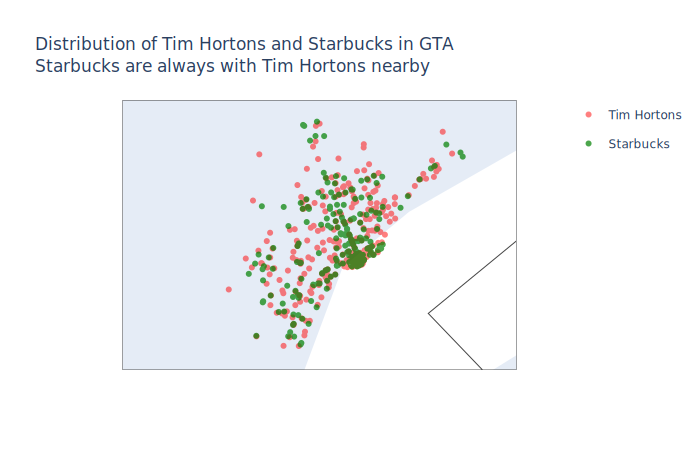

In [347]:
SVG('result_images' + os.sep + 'tim_star.svg')

According to the visualization on the GTA map, it is not hard to observe the number of red points(Tim Hortons) is almost same to the number of green ponts(Starbucks), which indicates the Tim Hortons and Starbucks are same prevalent in GTA.

However, some Tim Hortons locate at the edge of the GTA, Starbucks cannot be found nearby. Therefore Tim Hortons is a little bit more common in the edge part of GTA, indicating that Tim Hortons is the more popular one in the edgs GTA than Starbucks.

In [41]:
# This function is to calculate the distance between two points with
# latitudes and longitudes. 
# Reference: https://www.geeksforgeeks.org/program-distance-two-points-earth/
def distance(lat1, lat2, lon1, lon2): 
      
    # The math module contains a function named 
    # radians which converts from degrees to radians. 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 
       
    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    
    c = 2 * asin(sqrt(a))  
     
    # Radius of earth in kilometers. Use 3956 for miles 
    r = 6371
       
    # calculate the result 
    return(c * r) 

In [42]:
# This function is to find the smallest distance for each element in df1 in 
# df2 according to its latitude and longitude.
def shortest_distance(df1, df2):
    shortest = []
    for i in range(len(df1)):
        lat1 = df1['latitude'][i]
        long1 = df1['longitude'][i]
        dist = -1
        for j in range(len(df2)):
            lat2 = df2['latitude'][j]
            long2 = df2['longitude'][j]
            
            # Calculate the distance.
            cur_dist = distance(lat1, lat2, long1, long2)
            
            # Update the shortest distance.
            if dist < 0 or dist > cur_dist:
                dist = cur_dist
        shortest.append(dist)
    
    return shortest

In [43]:
tim_hortons_shortest = shortest_distance(tim_hortons, starbucks)
starbucks_shortest = shortest_distance(starbucks, tim_hortons)

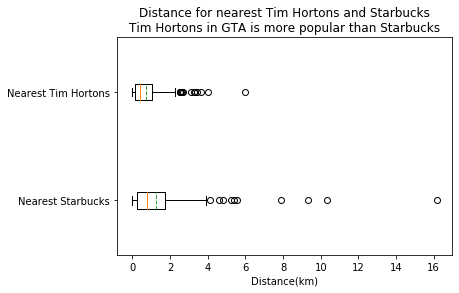

In [274]:
plt.boxplot(np.array([tim_hortons_shortest, starbucks_shortest]), labels=['Nearest Starbucks', 'Nearest Tim Hortons'], showmeans=True, meanline=True, vert=0)
plt.title('Distance for nearest Tim Hortons and Starbucks\nTim Hortons in GTA is more popular than Starbucks')
plt.xlabel('Distance(km)')
plt.show()

**Conclusion**

The green line represents the mean of all distance and the orange line indicate the median of the distance set. According to the boxplt above, both median and mean of nearest Starbucks for Tim Hortons is greater than the the nearest Tim Hortons for Starbucks.

This implies that there may be Tim Hortons with Starbucks far away while for all Starbucks are not hard to find a Tim Hortons nearby. Thus, this result indicates the idea from the map is true and shows that a person is easier to find Tim Hortons than Starbucks in GTA.

## Reviews

In [45]:
# Read review.json and save it in dataframe.
reviews = make_dataframe('review.json')

### Is there a small group of users responsible for most reviews?

**Methods:**
1. Calculate how many reviews given for each user.
2. Visualize the relation between total number of user and total number of reviews.

In [46]:
# Count the number of reviews given for each user,
user_reviews_count = reviews.user_id.value_counts(ascending=True)

# Find the culmalative sum.
s = 0
value_cnt_lst = []
for key, cnt in user_reviews_count.iteritems():
    value_cnt_lst.append(s + cnt)
    s += cnt

In [47]:
# Find number of users provided half of reviews.
index = 0
while value_cnt_lst[index] < 3342950:
    index += 1

# Find number of users provided 3/4 of reviews.
index = 0
while value_cnt_lst[index] < 1671475:
    index += 1

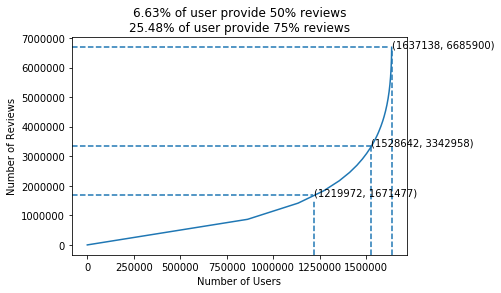

In [48]:
# Visualze the result.
plt.plot(value_cnt_lst)
plt.text(len(value_cnt_lst), len(reviews), '(' + str(len(value_cnt_lst)) + ', ' + str(len(reviews)) + ')')
plt.text(1528642, 3342958, '(1528642, 3342958)')
plt.text(1219972, 1671477, '(1219972, 1671477)')
plt.axhline(len(reviews), xmin=0.0, xmax=0.95, linestyle='dashed')
plt.axhline(3342958, xmin=0.0, xmax=0.9, linestyle='dashed')
plt.axhline(1671477, xmin=0.0, xmax=0.72, linestyle='dashed')

plt.axvline(len(value_cnt_lst), ymin=0.0, ymax=0.95, linestyle='dashed')
plt.axvline(1528642, ymin=0.0, ymax=0.5, linestyle='dashed')
plt.axvline(1219972, ymin=0.0, ymax=0.25, linestyle='dashed')

plt.xlabel('Number of Users')
plt.ylabel('Number of Reviews')
plt.title('6.63% of user provide 50% reviews\n25.48% of user provide 75% reviews')
plt.show()

**Explanation:**
X-axis represents the total number of users while y-axis represents the cumulative total number of reviews. For example, the points labeled as (1219972, 1671477) indicates that first 1219972 users provided 1671477 reviews.

**Conclusion:**

The plot implies 6.63% of users provide 50% reviews while 25.48% provide 75% of total reviews. According to this results, **there is a small group of users responsible for most reviews.** 

However, it is necessary to be aware of the reliability of the reviews of those users because some of them may be paid user which means those used are paid for giving good comments for some business.

### Do Yelp reviewers use similar language in their reviews of GTA's Tim Horton's and Starbucks?

Starbucks is one of the most famous coffee franchise in the US while Tim Horton's is the most popular franchise in Canada. All of these two franchises can be considered as coffee shops. Therefore, it is interesting to investigate whether customers for both Tim Hortons and Starbucks use similar language in their reviews.

Second Cup is also a relavent coffee shop in Canada. In order to analysis the language in reviews of GTA's Tim Horton's and Starbucks, the second cup is used to be compared group. Because its style is more similar to Starbucks which are both coffee shops while second cup and Tim Horton's are all Canadian business. Thus second cup will be an effective compared group.

To find the language using in reviews, I will analysis it in two parts:
- Top noun phrases describing each of the franchise.
- Reviews sentiment score of each brand.

#### Top noun phrases decribe Tim Hortons, Starbucks and Second Cup

**Method:**
1. Clean the data. For each review, I extract all noun phrase in the review text and collect them.
2. In Tim Horton's data, the tim hortons can be represented in multiple ways in different reviews such as Tim Hortons, Tim Horton's, Timmies, etc. Then I uniform the name and sum all these words to Tim Hortons.
3. Find the top frquences of noun phrases for each franchise. 
4. Visualize the result in word cloud.

In [263]:
tim_simple = tim_hortons[['business_id', 'stars', 'review_count', 'name']]
second_cup_simple = second_cup[['business_id', 'stars', 'review_count', 'name']]
starbucks_simple = starbucks[['business_id', 'stars', 'review_count', 'name']]

In [264]:
tim_reviews = reviews.merge(tim_simple, on='business_id', how='inner', suffixes=['_review', '_business'])
second_cup_reviews = reviews.merge(second_cup_simple, on='business_id', how='inner', suffixes=['_review', '_business'])
starbucks_reviews = reviews.merge(starbucks_simple, on='business_id', how='inner', suffixes=['_review', '_business'])

In [265]:
def find_words(df):
    counter = Counter()
    for i in range(len(df)):
        counter += Counter(TextBlob(df.text[i]).np_counts)
        
    np_df = pd.DataFrame.from_dict({'words': list(counter.keys()), 'count': list(counter.values())})
    sorted_np = np_df.sort_values(by='count', ascending=False).reset_index(drop=True)

    return sorted_np

In [266]:
def generate_frequence(df):
    frenquence = {}
    for i in range(len(df)):
        frenquence[df['words'][i]] = df['count'][i]
    
    return frenquence

In [285]:
tim_np = find_words(tim_reviews)
s = 0
drop_index = []
for i in range(len(tim_np)):
    if 'tim' in tim_np.words[i]:
        s += tim_np['count'][i]
        drop_index.append(i)
        
drop_index.remove(0)
tim_np.loc[0, 'count'] = s
tim_np = tim_np.drop(index=tim_np.index[drop_index]).reset_index(drop=True)

second_cup_np = find_words(second_cup_reviews)

starbucks_np = find_words(starbucks_reviews)

After extract all noun phrases for each franchise, we find that there are 10706 different noun phrases to describe Starbucks which is the most while there are only 4019 different phrases to label the second cup which is also the least one. 6741 noun phrases are used to describe Tim Hortons. Then I will show the top word to describe those franchise.

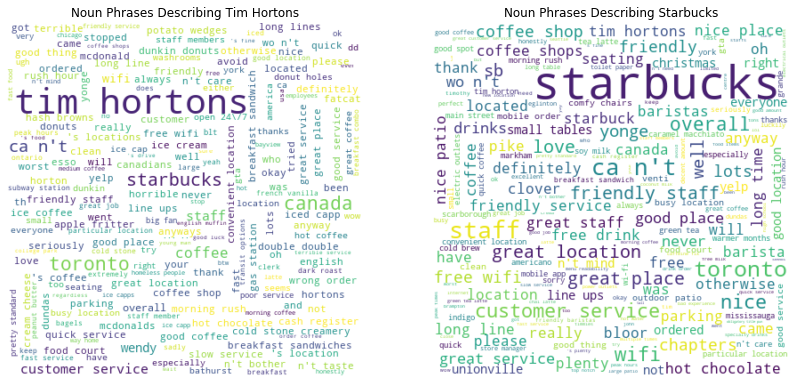

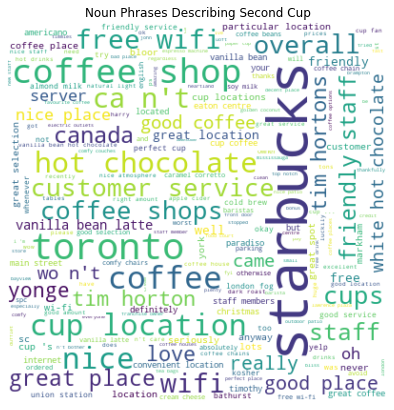

In [268]:
tim_frequence = generate_frequence(tim_np)
second_cup_frequence = generate_frequence(second_cup_np)
starbucks_frequence = generate_frequence(starbucks_np)

tim_word_cloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(tim_frequence)
second_cup_word_cloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(second_cup_frequence)
starbucks_word_cloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(starbucks_frequence)

fig, ax = plt.subplots(1, 2, figsize=(14, 14))
ax[0].imshow(tim_word_cloud, interpolation='bilinear')
ax[0].set_axis_off()
ax[0].set_title('Noun Phrases Describing Tim Hortons')

ax[1].imshow(starbucks_word_cloud, interpolation='bilinear')
ax[1].set_axis_off()
ax[1].set_title('Noun Phrases Describing Starbucks')

plt.show()

plt.figure(figsize=(7, 7))
plt.imshow(second_cup_word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Noun Phrases Describing Second Cup')

plt.show()

In order to gain a better visualization, Second Cup is put at the bottom of Tim Hortons and Starbucks which is convenient to compare each of those two word clouds.

**Conclusion:**

It is interesting to find that the most popular phrase to describe Starbucks and Second Cup are all starbucks which indicates that the customers in Second Cup would like to use Second Cup to compare with Starbucks. The most popular phrase for Tim Hortons reviews is Tim Horton's. However we still can find Starbucks in Tim Hortons reviews. Then I suppose that Starbucks is still the benchmark of coffee shop industry because even if people in other shops, they still like to use Starbucks as the standard level.

In addition, the other popular phrase to describe these two business is coffee shop, which implies the property of these two business while it is hard to find coffee shop phrase in Tim Hortons reviews. Though we can find it, notice that the word is really tiny. However, we can find donuts, food court, breakfast sandwich to describe Tim Hortons. Therefore Tim Hortons is more likely to restaurant while second cup and starbucks are literally coffee shops.



 #### Sentiment of reviews for Tim Hortons, Starbucks and Second Cup

**Method:**
1. Find the sentiment score of each review text according to each franchise.
2. Visualize the distribution of polarity score of each business in boxplot.

In [269]:
tim_star_second_reviews = pd.concat([tim_reviews, starbucks_reviews, second_cup_reviews])
tim_star_second_reviews['polarity'] = [TextBlob(text).sentiment[0] for text in tim_star_second_reviews['text']]

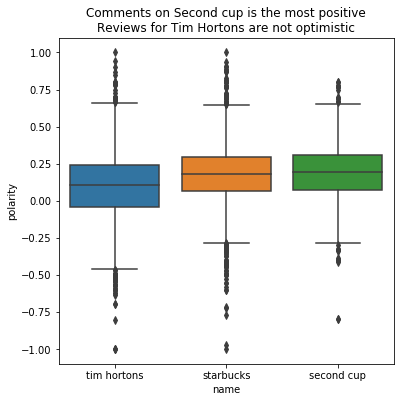

In [275]:
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x='name', y='polarity', data=tim_star_second_reviews)
ax.set_title('Comments on Second cup is the most positive\nReviews for Tim Hortons are not optimistic')
plt.show()

Based on the boxplot above, the observation that the second cup's polarity score is the highest which indicates the people tend to give second cup positive reviews. On the other hand, the meadian of Tim Hortons is the lowest. This shows that Tim Hortons need to do more in order to catch up with Starbucks and Second Cup.

**Conclusion:**

Based on the result we get, we can conlude that people would like to use similar word to describe those three franchise. We can see customers often compare those three most popular coffee shops to each other. In addition, people always give feedback on the service, environment, flavor and location aspects which share a large number of similar words.

Nevertheless, we still can find which franchise have a better quality regarding to the polarity analysis. We can notice that the polarity of starbucks and second cup are higher than the polarity of Tim Hortons obviously which might indicate Tim Hortons need to make more progress.

**Discussion**

The visualization of polarity distribution indicates that the number of comments received by Second Cup is less than Tim Hortons and Starbucks, then this may cause an error when we doing the analysis. In addition, when we find the noun phrases, since I used API of TextBlob directly, I do not know the algorithm of this NLP tool. Therefore, when it finds noun phrases, it might make some mistakes such as it may consider second cup as cup. Then the error might occor. Therefore, when we analysis the reuslt, we had better consider what kind of aspects the comments of customers relating to. Then in each aspects, we can find some similar words.

### Can we automatically detect "paid reviewers" (i.e. people who are paid to write positive reviews)?

It is difficult to detect paid reviewers. The method is provided as following, however there exists a lot of limitaions and restrictions to the method which will be discussed after the method.

**Method**
1. For each business find the reviews with abnormal star which is defined as the outliers of the score distribution. 
2. Find all the reviews that this reviewer given, calculate the number of the reviews with abnormal star that the user made, the more reviews represents higher probability the user is paid reviewer.
3. If the user only have several reviews given this can be set to less than 3 and every reviews are extremely vivid, then the user also can be considered as paid reviewer.

**Reason**

By common sense, no paid reviewers will want others know they are paid, then they will try their best to be normal. However, the star might be abnormal which can have impact the average star rating. In addition, paid reviewers will write fantastic essays to attract others. But paid reviewers are not likely to use their own account which means they may create other account which is used to write "fake reviews". Therefore, the method above indicates these aspects.

**Discussion**

There are lots of restriction to this method.

First it is hard to define what are paid reviewers even if we know the idea of paid reviewers are those people who are paid to write positive reviews. However there are multiple ways to pay, including paid directly, offering free dessert after having meal or offering coupons. Besides, there are multiple kinds of paid reviewers, some business may paid users for providing positive reviews to themselves while some other merchants might paid users to give negative feedback to their components.

Besides that, what paid reviewers' "fake reviews" can be also different. Some of them can provide an extremely high score reviews or extremely low scores to make the average star change. Or they can write a fantastic essay to the reviews but with a normal score even with photos inserted, then other customers will come to the business after reading the review. There also are some paid reviewers can make them seems like the person had been to the business although they have not.

In addition, the methods I come up with to detect paid reviewers cannot work well because I do not know whether the user is actually a paid reviewers, then I cannot measure effectiveness of the method. Even if I use some machine learning methods or supervised learning method, beacuse of lack of answers. 

Not to say automatically detect "paid reviewers", I look into the reviews given by some users, I cannot say whether the user is a paid reviewer. What I can do is to give the idea that whether I think the user is a paid reviewer or to say the probability of the user is a paid reviewer, which is really subjective. In this way, some people may disagree on me. 

On the other hand, the criterias to judge if a reviewer is a paid reviewer, there still exists the possibility that I consider the user is paid reviewer but actually the reviewer is not. In addition, the scoring criterias are different for from people to people. Some people will always give 5 stars and some of them may never give 1 star. There are lots of people do not like to write reviews, therefore only some reviews can be found among all reviews provided by the user. In this way, those normal reviewers will have influence on the judgement of paid reviewers. 

The method I given is based on my personal understanding of paid reviewers this may be not accurate or this is subjective. To be more rigorous, the method I given can only filter those "weird" reviewers but I cannot prove they are paid reviewers. Because paid reviewers can be normal and normal reviewers can be weird and we even cannot tell the proportion of these two types of people in the whole population.

